In [17]:
import numpy as np
import tensorflow as tf
import flowpm
import tensorflow_probability as tfp

In [18]:
cosmo={"w0":-1.0,
       "wa":0.0,
       "H0":100,
       "h":0.6774,
       "Omega0_b":0.04860,
       "Omega0_c":0.2589,
       "Omega0_m":0.3075,
       "Omega0_k":0.0,
       "Omega0_de":0.6925,
       "n_s":0.9667,
       "sigma8":0.8159}

In [19]:
def fde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (-3.0*(1.0+w0)+
            3.0*wa*((a-1.0)/tf.math.log(a-epsilon)-1.0))

In [20]:
def w(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return w0+wa*(1.0-a)


In [21]:
def E(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return(tf.math.sqrt(
        cosmo["Omega0_m"]/tf.math.pow(a, 3)
        +cosmo["Omega0_k"]/tf.math.pow(a, 2)
        +cosmo["Omega0_de"]*tf.math.pow(a, fde(cosmo,a))))

In [22]:
def H(cosmo, a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["H0"]*cosmo["h"] *(E(cosmo, a))

In [23]:
def dfde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (3*wa*
            (tf.math.log(a-epsilon)-(a-1)/(a-epsilon))
            /tf.math.pow(tf.math.log(a-epsilon),2))

In [24]:
def dEa(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return 0.5*(-3*cosmo["Omega0_m"]/tf.math.pow(a, 4)-2*cosmo["Omega0_k"]/tf.math.pow(a, 3)
    +dfde(cosmo,a)*cosmo["Omega0_de"]*tf.math.pow(a, fde(cosmo,a)))
    


In [25]:
def Omega_m_a(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["Omega0_m"]*tf.math.pow(a,-3)/E(cosmo,a)**2

In [26]:
def Omega_de_a(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["Omega0_de"]*tf.math.pow(a,fde(cosmo,a))/E(cosmo,a)**2

In [27]:
log10_amin=-3
steps=128
atab =np.logspace(log10_amin, 0.0, steps)
#y0=tf.constant([atab[0],1.0],dtype=tf.float32)
y0=tf.constant([0.001,1.0],dtype=tf.float32)

In [28]:
#Equation 1.96 from Florent Leclercq thesis

#@tf.function
def growth_func(a,y):
    y=tf.convert_to_tensor(y,dtype=tf.float32)
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    d,d_f=y
    dydt= d_f,1.5*Omega_m_a(cosmo,a)*d/tf.pow(a,2)-(d_f/a)*(Omega_de_a(cosmo,a)-0.5*Omega_m_a(cosmo,a)+2)
    return dydt     

In [29]:
#@tf.function
def odesolve_func(atab,y0):
    solver=tfp.math.ode.BDF()
    results = solver.solve(growth_func,atab[0], y0, solution_times=atab)
    return results

In [30]:
results_func=odesolve_func(atab,y0)

Populating the interactive namespace from numpy and matplotlib


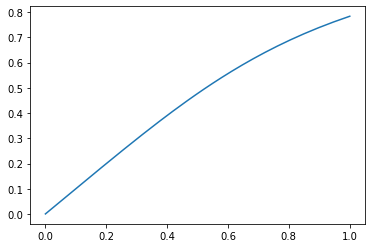

In [31]:
%pylab inline
plot(results_func.times,results_func.states[:,0])
#savefig("growt_function.png",dpi=200)

In [32]:

#comparison with background.py

from flowpm.background import MatterDominated

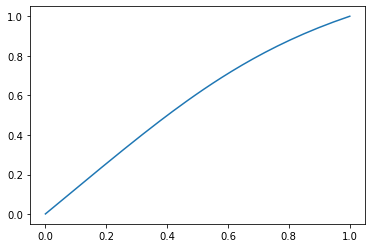

In [33]:
M_d=MatterDominated(Omega0_m=0.3075)
M_d.D1(results_func.times)
plot(results_func.times,M_d.D1(results_func.times))

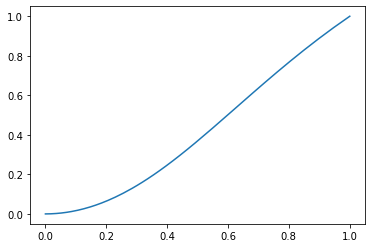

In [34]:
plot(results_func.times,M_d.D2(results_func.times))

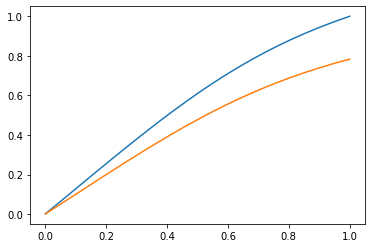

In [37]:
plot(results_func.times,M_d.D1(results_func.times))
plot(results_func.times,results_func.states[:,0])

In [38]:
from jax_cosmo.background import growth_factor
from jax_cosmo.parameters import Planck15

In [39]:
cosmo=Planck15()


In [40]:
growth_factor(cosmo, atab)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


DeviceArray([0.00127641, 0.00134776, 0.0014231 , 0.00150264, 0.00158664,
             0.00167533, 0.00176898, 0.00186786, 0.00197227, 0.00208252,
             0.00219893, 0.00232184, 0.00245163, 0.00258867, 0.00273337,
             0.00288616, 0.00304749, 0.00321784, 0.00339772, 0.00358764,
             0.00378818, 0.00399994, 0.00422353, 0.00445961, 0.0047089 ,
             0.00497212, 0.00525005, 0.00554352, 0.00585339, 0.00618059,
             0.00652607, 0.00689086, 0.00727605, 0.00768277, 0.00811222,
             0.00856568, 0.00904449, 0.00955006, 0.01008389, 0.01064756,
             0.01124274, 0.01187119, 0.01253476, 0.01323543, 0.01397527,
             0.01475646, 0.01558132, 0.01645228, 0.01737193, 0.01834299,
             0.01936833, 0.02045098, 0.02159414, 0.02280121, 0.02407575,
             0.02542152, 0.02684253, 0.02834296, 0.02992725, 0.0316001 ,
             0.03336645, 0.03523153, 0.03720085, 0.03928024, 0.04147585,
             0.04379416, 0.04624205, 0.04882672, 0.

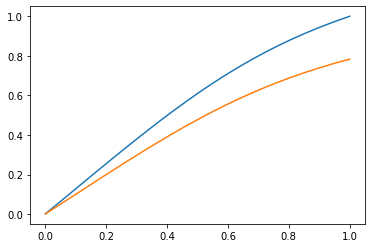

In [25]:
plot(atab,growth_factor(cosmo, atab))
plot(results_func.times,results_func.states[:,0])

In [99]:
def scdm(a,y):
    y=tf.convert_to_tensor(y,dtype=tf.float32)
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    d,d_f=y
    dydt= d_f,1.5*d/a-1.5*d_f/a
    return dydt   

In [100]:
#@tf.function
def odesolve_func_scdm(atab,y0):
    solver=tfp.math.ode.BDF()
    results = solver.solve(scdm,atab[0], y0, solution_times=atab)
    return results

In [101]:
results_func_scdm=odesolve_func_scdm(atab,y0)